This is the code related to chapter 31 of Intuitive Biostatistics 4th (H. Motulsky, OUP, 2018).
We will compare two paired groups.
Note that we are talking about the mean of difference between 'before' and 'after', instead of the difference betweens the means as discussed in chapter 30 (unpaired groups).

### Paired t test

#### Import libraries and data

In [24]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
# the data come from Table 31.1 on page 307
cross = np.array([23.5, 12, 21, 22, 19.125, 21.5, 22.125, 20.375,
                 18.250, 21.625, 23.250, 21, 22.125, 23, 12])
self =  np.array([17.375, 20.375, 20, 20, 18.375, 18.625, 18.625, 15.25,
                 16.5, 18, 16.25, 18, 12.75, 15.5, 18])

In [26]:
difference = cross - self
print(difference)

[ 6.125 -8.375  1.     2.     0.75   2.875  3.5    5.125  1.75   3.625
  7.     3.     9.375  7.5   -6.   ]


#### Data visualization

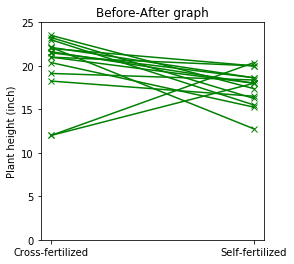

In [27]:
plt.figure(figsize=(4,4))
plt.plot([cross, self], 'gx-')
plt.xticks([0, 1], ['Cross-fertilized', 'Self-fertilized'])
plt.ylim(0, 25)
plt.title('Before-After graph')
plt.ylabel('Plant height (inch)');

#### Descriptive statistics and paired t test

In [28]:
from scipy import stats

In [29]:
mean_diffs = np.mean(cross - self)
print(f"Mean of differences = {mean_diffs:4.3f}")

Mean of differences = 2.617


In [30]:
sem_diffs = stats.sem(cross - self)
print(f"SEM of differences = {sem_diffs:4.3f}")

SEM of differences = 1.218


In [31]:
t_ratio = mean_diffs / sem_diffs
print(f"t ratio = {t_ratio:4.3f}")

t ratio = 2.148


In [32]:
t, p_value = stats.ttest_rel(cross, self)

In [33]:
print(f"P value from paired t test = {p_value:5.4f}")

P value from paired t test = 0.0497


The H0 is there is no difference in the heigth of the 2 kinds of plants, i.e. the differences that we measure are sampled from a population for which the average difference is zero.
The P value is 0.0497. If the H0 were true, 5% of random samples of 15 pairs would have a difference this large of larger.
Assuming that the H0 is true, the probability of observing a difference as large as that observed here with the self-fertilized plants frowing more than the cross-fertilized plants is 0.0248.

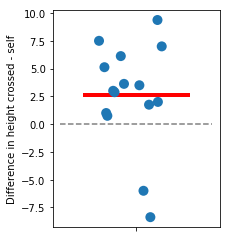

In [35]:
import seaborn as sns
plt.figure(figsize=(3,4))
sns.stripplot(y=cross - self, size=10,)
plt.ylabel('Difference in height crossed - self')
plt.hlines(y=0, xmin=-.2, xmax=.2, colors='gray', linestyles='--')
plt.hlines(y=mean_diffs, xmin=-.14, xmax=.14, colors='red', linewidth=4, label='mean');

#### Computation of the CI

In [36]:
# we compute the ci using the t* distribution and SEM
t_ = stats.t(df = len(cross - self) - 1).ppf((1 + .95) /2) # two-tailed
W = t_ * sem_diffs
print(f"Confidence interval of the mean of differences = {(mean_diffs - W, mean_diffs + W)}")

Confidence interval of the mean of differences = (0.00389916480019048, 5.2294341685331425)


In [37]:
ci_bayes = stats.bayes_mvs(cross - self, alpha=.95)[0][1] # gives the same
print(f"Confidence interval of the mean of differences = {ci_bayes}")

Confidence interval of the mean of differences = (0.00389916480019048, 5.2294341685331425)


#### Bootstraping analysis

In [38]:
diffs_shifted = (cross - self) - mean_diffs + 0 # H0 is difference = 0

In [39]:
bs_diffs_shft = [np.mean(np.random.choice(
    diffs_shifted, size=len(diffs_shifted))) for _ in range(10000)]

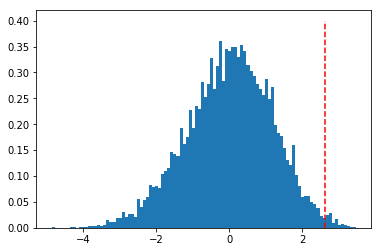

In [40]:
plt.hist(bs_diffs_shft, density=True, bins=100)
plt.vlines(mean_diffs, 0, .4, color='red', linestyles='--');

In [41]:
p_bs = np.sum(bs_diffs_shft >= mean_diffs) / len(bs_diffs_shft)

In [42]:
print(f"P value from bootstraping = {p_bs:5.4f}")

P value from bootstraping = 0.0087


In [43]:
# the last test did not really work, let's try another test statistic (permutation)
# cross_perm = np.random.permutation(cross) will permute the pairs
# we only need to calculate the mean differences over the permuted pairs

In [44]:
bs_mean_diffs = [np.mean(np.random.permutation(cross) - self) for _ in range(10000)]

In [45]:
np.sum(bs_mean_diffs >= mean_diffs) / len(bs_mean_diffs)
# I am still not sure how to handle this situation using bootstap replicates...

1.0

In [50]:
# let's try to test if samples are from the same distribution
combined = np.concatenate([cross, self])

In [47]:
bs_mean_diffs = []

for _ in range(10000):
    permut = np.random.permutation(combined)
    bs_cross = permut[:len(cross)]
    bs_self  = permut[len(self):]
    
    bs_mean_diffs.append(np.mean(bs_cross - bs_self))

In [48]:
P_value_bs = np.sum(bs_mean_diffs >= mean_diffs) / len(bs_mean_diffs)
print(f"P value obtained using bootstraping = {P_value_bs:7.6f}")

P value obtained using bootstraping = 0.010700


Still not convinced how to do...

Since paired data are analyzed by creating the individual difference between each pair, the simulation should also create data as the difference between two variates. __Paired data exhibit a correlation between the two variates__. As this correlation between the variates increases, the variance of the difference decreases. Thus it is important not only to specify the distributions of the two variates that will be differenced, but to also specify their correlation.
Obtaining paired samples from arbitrary distributions with a set correlation is difficult because the joint, bivariate distribution must be specified and simulated.

The **one-sample t-test** assumes that the data are a simple random sample from a population of normallydistributed values that all have the same mean and variance. The one-sample bootstrap procedure for testing whether the mean is equal to a specific value is given in Efron & Tibshirani (1993) pages 224-227.

In [34]:
# we use the sample mean
mean_diffs

2.6166666666666667

In [52]:
# we compute the sample t value
M0 = 0 # 0 is the value of H0
t_val = (mean_diffs - M0) / sem_diffs 

In [54]:
# draw replicats from the original difference array and compute the bootstrap stat test
reps = np.random.choice(difference, size=len(difference))
bs_t_reps = (np.mean(reps) - mean_diffs) / stats.sem(reps)
print(bs_t_reps)

-0.4462896278327198


In [ ]:
# For a two-tailed test, if bs_t_reps > t_val then add 1 to a counter variable A
# Repeat the steps B times (B may be anywhere from 100 to 10_000)
# p-value of the bootstrap test as (A + 1) / (B + 1)

# Repeat these steps M times, where M is the number of simulations. The power and 
# significance level is equal to the percent of the time the p-value is less than 
# the nominal alpha of the test.

In [58]:
A,B = 0,10000
for n in range(B):
    reps = np.random.choice(difference, size=len(difference))
    bs_t_reps = (np.mean(reps) - mean_diffs) / stats.sem(reps)
    if bs_t_reps > t_val: A+=1

p_val_bs = A/B
print(f'P value from the bootstrap one-sample test = {p_val_bs:4.3f}')

P value from the bootstrap one-sample test = 0.068


#### Correlation

In [ ]:
plt.figure(figsize=(4,3))
plt.scatter(cross, self)
plt.title('Testing the need for a paired t test')
plt.xlabel('Cross-fertilized')
plt.ylabel('Self-fertilized');

In [ ]:
pearson_r = np.corrcoef(cross, self)[0,1]
print(f"Pearson coeffecient of correlation = {pearson_r:3.2f}")

### Ratio paired t test

In [ ]:
control = np.array([24, 6, 16, 5, 2])
treated = np.array([52, 11, 28, 8, 4])

In [ ]:
plt.figure(figsize=(6,4))
plt.subplot(121)
plt.plot([control, treated], 'mx-')
plt.xticks([0, 1], ['Control', 'Treated'])
plt.ylim(0, 60)
plt.title('Before-After graph')
plt.ylabel('Enzyme activity')

plt.subplot(122)
sns.stripplot(y=treated - control, size=10,)
plt.ylabel('Difference treated - control')
plt.hlines(y=np.mean(treated - control), xmin=-.14, xmax=.14, 
           colors='red', linewidth=4, label='mean')
plt.tight_layout();

The difference between control and treated depends on where we start. Clones with higher enzyme activity in control condition have a larger increment with treatment.

In [ ]:
plt.plot([control, treated], 'mo-', lw=3)
plt.xticks([0, 1], ['Control', 'Treated'])
plt.yscale('log')
plt.title('Before-After graph')
plt.ylabel('Enzyme activity (log)'); # with a log y-axis, all five increases are ca. same size

In [ ]:
factor = 10 ** (np.mean(np.log10(treated) - np.log10(control)))
print(f"On average the treatment multiplies enzyme activity by {factor:3.2f}")

In [ ]:
t_10, p_value_10 = stats.ttest_rel(np.log10(treated), np.log10(control))
print(f"t and P value for that ratio paired t test are {t_10:5.3f} and {p_value_10:5.4f}")

In [ ]:
p_value_10

In [ ]:
ci_bayes_log = stats.bayes_mvs(np.log10(treated) - np.log10(control), 
                                 alpha=.95)[0][1]
ci_bayes_ratio = 10 ** np.array(ci_bayes_log)
print(f"Confidence interval of the mean of differences = {ci_bayes_ratio}")

This interval doesn't include 1.0 (a ratio of 1.0 means no change)